<a href="https://colab.research.google.com/github/silveirafatup-maker/DIO/blob/main/recomendacao_visual_produto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Observações sobre os códigos.
##1- Sistema de Recomendação Visual:
###Este modelo é didático e funcional para pequenos catálogos. No entanto, ele é inviável para produção, pois a latência de busca cresce linearmente com o número de produtos (se dobrarem os produtos, dobra o tempo de busca), e ele é limitado pela memória RAM do ambiente de execução (o Colab).

##2- Sistema de Recomendação Visual com Vertex AI Vector Search:
###Este modelo é uma arquitetura pronta para produção em escala web. Ele extrai o vetor da imagem de pesquisa e o envia como payload para o serviço Vertex AI Vector Search. Em resumo, é uma arquitetura de produção industrializada usando os conceitos e ferramentas de MLOps



# 1- Sistema de Recomendação Visual

### CÉLULA 1: PREPARAÇÃO DO AMBIENTE E DOWNLOAD DE AMOSTRAS

In [1]:
# Instalações e Imports
!pip install tensorflow numpy matplotlib scikit-learn Pillow -q

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Caminhos
CATALOGO_DIR = 'catalogo_produtos'
IMAGEM_PESQUISA = 'produto_pesquisa.jpg'
K_RECOMENDACOES = 3 # Número de sugestões a retornar

# Cria diretórios e baixa imagens de amostra para simular o catálogo e a busca
if not os.path.exists(CATALOGO_DIR):
    os.makedirs(CATALOGO_DIR)

# Simulação de imagens de catálogo (URLs simples de amostra)
URL_CATALOGO_1 = "https://picsum.photos/id/21/200/200" # sapato
URL_CATALOGO_2 = "https://picsum.photos/id/238/200/200" # Montanha
URL_CATALOGO_3 = "https://picsum.photos/id/239/200/200" # Céu
URL_CATALOGO_4 = "https://picsum.photos/id/240/200/200" # Flores
# imagem identica a 1, o score de similaridade será alto
URL_CATALOGO_5 = "https://picsum.photos/id/21/200/200" # sapato similar

# Imagem para pesquisa
URL_PESQUISA = "https://picsum.photos/id/21/200/200" # sapato feminino

# baixa os arquivos
os.system(f"wget {URL_CATALOGO_1} -O {CATALOGO_DIR}/produto_A_sapato_1.jpg -q")
os.system(f"wget {URL_CATALOGO_2} -O {CATALOGO_DIR}/produto_B_montanha.jpg -q")
os.system(f"wget {URL_CATALOGO_3} -O {CATALOGO_DIR}/produto_C_ceu.jpg -q")
os.system(f"wget {URL_CATALOGO_4} -O {CATALOGO_DIR}/produto_D_flores.jpg -q")
os.system(f"wget {URL_CATALOGO_5} -O {CATALOGO_DIR}/produto_E_sapato_similar.jpg -q")
os.system(f"wget {URL_PESQUISA} -O {IMAGEM_PESQUISA} -q")

print("Setup concluído. 5 imagens de catálogo e 1 imagem de pesquisa baixadas para o ambiente local.")


Setup concluído. 5 imagens de catálogo e 1 imagem de pesquisa baixadas para o ambiente local.


## CÉLULA 2: FUNÇÃO DE PRÉ-PROCESSAMENTO E EXTRAÇÃO DE FEATURES


In [2]:
# Carrega a ResNet50 (pré-treinada no ImageNet)

modelo_feature_extractor = ResNet50(weights='imagenet', include_top=False, pooling='avg')

print("Modelo ResNet50 (Extrator de Features) carregado com sucesso.")


def carregar_e_pre_processar(caminho_imagem, tamanho_alvo=(224, 224)):
    """Carrega uma imagem e a prepara para a ResNet50."""
    try:
        img = image.load_img(caminho_imagem, target_size=tamanho_alvo)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
        return img_array
    except Exception as e:
        print(f"Erro ao carregar/processar imagem {caminho_imagem}: {e}")
        return None

def extrair_features(caminho_imagem):
    """Extrai o vetor de features (assinatura) da imagem."""
    imagem_processada = carregar_e_pre_processar(caminho_imagem)
    if imagem_processada is not None:
       features = modelo_feature_extractor.predict(imagem_processada, verbose=0)
       return features[0]
    return None


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Modelo ResNet50 (Extrator de Features) carregado com sucesso.


## CÉLULA 3: MODELO E EXTRAÇÃO DE FEATURES


In [3]:
# Carrega a ResNet50 (pré-treinada no ImageNet)
modelo_feature_extractor = ResNet50(weights='imagenet', include_top=False, pooling='avg')

print("Modelo ResNet50 (Extrator de Features) carregado com sucesso.")

def extrair_features(caminho_imagem):
    # Extrai o vetor de features (assinatura) da imagem
    imagem_processada = carregar_e_pre_processar(caminho_imagem)
    if imagem_processada is not None:
        features = modelo_feature_extractor.predict(imagem_processada, verbose=0)
        return features[0]
    return None


Modelo ResNet50 (Extrator de Features) carregado com sucesso.


## CÉLULA 4: CONSTRUÇÃO DO CATÁLOGO E BUSCA POR SIMILARIDADE (Distância Cosseno)



--- 4.1. Construindo o Catálogo de Features ---
Catálogo criado. Total de 5 produtos processados.

--- 4.2. Processando a Imagem de Pesquisa ---

--- 4.3. Calculando Similaridade (Busca) ---

 Top 3 Sugestões encontradas no catálogo local:


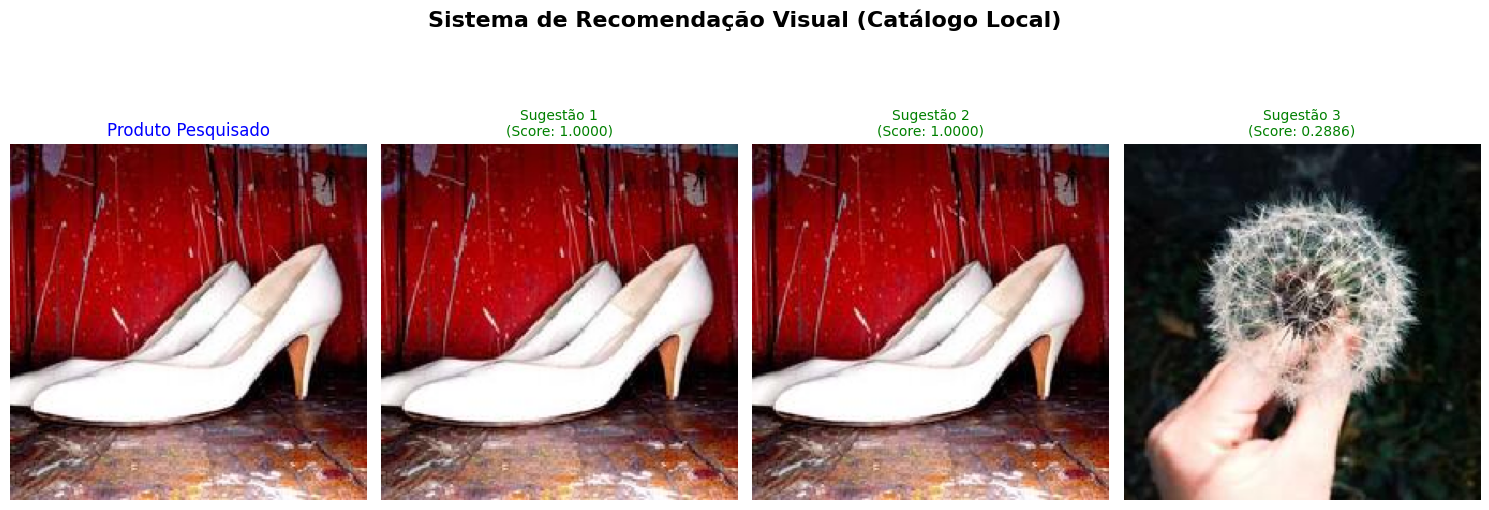

In [5]:
# Dicionário para armazenar o catálogo:
# {'caminho/do/arquivo.jpg': vetor_features}

catalogo_features = {}

# 4.1. Construir o Catálogo (Processar todas as imagens locais)
print("\n--- 4.1. Construindo o Catálogo de Features ---")
caminhos_imagens = [os.path.join(CATALOGO_DIR, f) for f in os.listdir(CATALOGO_DIR)]

for caminho in caminhos_imagens:
    features = extrair_features(caminho)
    if features is not None:
        catalogo_features[caminho] = features

print(f"Catálogo criado. Total de {len(catalogo_features)} produtos processados.")

# 4.2. Extrair a Feature da Imagem de Pesquisa
print("\n--- 4.2. Processando a Imagem de Pesquisa ---")
feature_pesquisa = extrair_features(IMAGEM_PESQUISA)

if feature_pesquisa is None:
    print("Falha crítica: Não foi possível processar a imagem de pesquisa.")
else:
# 4.3. Calcular a Similaridade (Busca)
    print("\n--- 4.3. Calculando Similaridade (Busca) ---")

    caminhos_catalogo = list(catalogo_features.keys())
    features_catalogo = np.array(list(catalogo_features.values()))

    # Compara o vetor de pesquisa com todos os vetores do catálogo (Distância Cosseno)
    similaridades = cosine_similarity(
        feature_pesquisa.reshape(1, -1),
        features_catalogo
    )[0]

    # 4.4. Ordenar e Selecionar os K Mais Similares
    # do score mais alto para o menor
    indices_ordenados = np.argsort(similaridades)[::-1]

    recomendados = []

    for i in indices_ordenados:
        caminho_recomendado = caminhos_catalogo[i]
        score = similaridades[i]

        # Ignora a própria imagem se for quase idêntica (opcional, para testes)
        if caminho_recomendado == IMAGEM_PESQUISA and score > 0.9999:
             continue

        recomendados.append({
            'caminho': caminho_recomendado,
            'score': score
        })

        if len(recomendados) >= K_RECOMENDACOES:
            break

    # 4.5. Apresentação dos Resultados
    print(f"\n Top {K_RECOMENDACOES} Sugestões encontradas no catálogo local:")

    # Apresentação Visual
    plt.figure(figsize=(15, 6))
    plt.subplot(1, K_RECOMENDACOES + 1, 1)
    img_pesquisa = image.load_img(IMAGEM_PESQUISA, target_size=(224, 224))
    plt.imshow(img_pesquisa)
    plt.title("Produto Pesquisado", color='blue')
    plt.axis('off')

    # Imagens Sugeridas
    for i, item in enumerate(recomendados):
        plt.subplot(1, K_RECOMENDACOES + 1, i + 2)

        img_sugerida = image.load_img(item['caminho'], target_size=(224, 224))
        plt.imshow(img_sugerida)

        nome_produto = os.path.basename(item['caminho']).replace(CATALOGO_DIR + '/', '')

        plt.title(f"Sugestão {i+1}\n(Score: {item['score']:.4f})", color='green', fontsize=10)
        plt.xlabel(nome_produto.replace('.jpg', ''), fontsize=8)
        plt.axis('off')

    plt.suptitle("Sistema de Recomendação Visual (Catálogo Local)", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# 2- Sistema de Recomendação Visual com Vertex AI Vector Search

### IMPORTANTE: Preencher os valores como PROJECT_ID, BUCKET_NAME, etc., com suas informações reais.

1. Célula: Autenticação (Upload do Arquivo JSON)

In [ ]:
# ==============================================================================
# CÉLULA 1A: UPLOAD E CONFIGURAÇÃO DA AUTENTICAÇÃO
# Esta etapa é OBRIGATÓRIA toda vez que você inicia a sessão do Colab.
# ==============================================================================
from google.colab import files
import os

print("Por favor, selecione e faça upload do seu arquivo de chave .json da Conta de Serviço:")
uploaded = files.upload()

key_file_name = None
for fn in uploaded.keys():
  print('Arquivo "{name}" enviado com sucesso.'.format(name=fn))
  key_file_name = fn

if key_file_name:
    # Define a variável de ambiente (o G Cloud a usa automaticamente)
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = key_file_name
    print(f"\n✅ Variável de ambiente configurada para: {key_file_name}")
else:
    print("❌ ERRO: Nenhum arquivo foi enviado. A autenticação falhará.")


# ==============================================================================
# CÉLULA 1B: INSTALAÇÕES, IMPORTS E CONFIGURAÇÕES DE NUVEM
# ==============================================================================
# Instalar bibliotecas essenciais para ML e Google Cloud
!pip install tensorflow numpy matplotlib scikit-learn Pillow google-cloud-storage google-cloud-aiplatform -q

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from google.cloud import storage, aiplatform
import io
import json

# --- CONFIGURAÇÕES DO GOOGLE CLOUD (SUBSTITUA PELOS SEUS VALORES REAIS) ---
PROJECT_ID = 'seu-project-id-real'
REGION = 'southamerica-east1'
BUCKET_NAME = 'nome-do-seu-bucket-de-produtos'

# CONFIGURAÇÕES DO VERTEX AI VECTOR SEARCH
# Estas informações vêm do seu recurso implantado no Google Cloud Console
ENDPOINT_ID = 'seu-endpoint-id-real' # Ex: '1234567890123456789'
DEPLOYED_INDEX_ID = 'seu-deployed-index-id-real' # Ex: 'deployed_index_fashion'

# Configuração de ML/Busca
IMAGEM_PESQUISA = 'produto_pesquisa.jpg'
K_RECOMENDACOES = 3

# Simulação: Baixa uma imagem local para simular a pesquisa do cliente
URL_PESQUISA = "https://picsum.photos/id/237/200/200"
os.system(f"wget {URL_PESQUISA} -O {IMAGEM_PESQUISA} -q")

# Inicialização do Vertex AI
aiplatform.init(project=PROJECT_ID, location=REGION)

print("\nSetup de Nuvem e Bibliotecas concluído.")


#2. Célula: Funções Auxiliares (Processamento e GCS)
Esta célula é quase idêntica à versão anterior, mas inclui a função download_imagem_gcs que é crucial para exibir os resultados da busca na nuvem.

In [ ]:
# ==============================================================================
# CÉLULA 2: FUNÇÕES DE PRÉ-PROCESSAMENTO, EXTRAÇÃO E DOWNLOAD DO GCS
# ==============================================================================

def carregar_e_pre_processar(caminho_imagem, tamanho_alvo=(224, 224)):
    """Carrega uma imagem local e a prepara para a ResNet50."""
    try:
        img = image.load_img(caminho_imagem, target_size=tamanho_alvo)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
        return img_array
    except Exception as e:
        print(f"❌ Erro ao carregar/processar imagem {caminho_imagem}: {e}")
        return None

# Carrega o modelo de feature extractor
modelo_feature_extractor = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extrair_features(caminho_imagem):
    """Extrai o vetor de features (assinatura) da imagem local de pesquisa."""
    imagem_processada = carregar_e_pre_processar(caminho_imagem)
    if imagem_processada is not None:
        # Apenas a imagem de pesquisa é processada localmente
        features = modelo_feature_extractor.predict(imagem_processada, verbose=0)
        return features[0]
    return None

def download_imagem_gcs(bucket_name, blob_name, tamanho_alvo=(224, 224)):
    """Baixa a imagem do produto sugerido do GCS para exibição."""
    try:
        storage_client = storage.Client(project=PROJECT_ID)
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(blob_name)
        image_bytes = blob.download_as_bytes()
        img = image.load_img(io.BytesIO(image_bytes), target_size=tamanho_alvo)
        return img
    except Exception as e:
        print(f"❌ Erro ao baixar imagem {blob_name} do GCS: {e}")
        return None

print("Funções de ML e GCS definidas.")


# 3. Célula: Busca na Nuvem e Visualização de Resultados
Esta célula é onde a lógica de busca local é totalmente substituída pela chamada ao serviço Vertex AI Vector Search.

In [ ]:
# ==============================================================================
# CÉLULA 3: BUSCA DE SIMILARIDADE USANDO VERTEX AI VECTOR SEARCH
# ==============================================================================

# --- 3.1. Extrair Feature da Imagem de Pesquisa (LOCAL) ---
print("\n--- 3.1. Processando a Imagem de Pesquisa Local ---")
feature_pesquisa = extrair_features(IMAGEM_PESQUISA)

if feature_pesquisa is None:
    raise ValueError("❌ Falha crítica: Não foi possível processar a imagem de pesquisa.")

# Formata o vetor para o formato que a API espera
feature_pesquisa_list = feature_pesquisa.reshape(1, -1).astype('float32').tolist()


# --- 3.2. Função de Busca na Nuvem (API) ---
def buscar_no_vector_search(vector):
    """Envia o vetor de features para o serviço implantado do Vector Search."""
    try:
        # Constroi o nome completo do recurso (Endpoint)
        endpoint_name_full = f"projects/{PROJECT_ID}/locations/{REGION}/indexEndpoints/{ENDPOINT_ID}"
        deployed_index_endpoint = aiplatform.IndexEndpoint(index_endpoint_name=endpoint_name_full)

        # Executa a chamada de vizinhos mais próximos, buscando K_RECOMENDACOES
        response = deployed_index_endpoint.find_neighbors(
            deployed_index_id=DEPLOYED_INDEX_ID,
            queries=vector,
            num_neighbors=K_RECOMENDACOES
        )

        return response[0].neighbors # Retorna a lista de vizinhos

    except Exception as e:
        print(f"❌ ERRO na chamada ao Vector Search: {e}")
        print("Verifique se o ENDPOINT_ID, DEPLOYED_INDEX_ID e as permissões estão corretas.")
        return []

# --- 3.3. Execução da Busca e Processamento de Resultados ---
print("\n--- 3.3. Executando Busca na Nuvem ---")
resultados_nuvem = buscar_no_vector_search(feature_pesquisa_list)

recomendados_nuvem = []

for vizinho in resultados_nuvem:
    # O 'vizinho.id' é o nome do blob no GCS (o nome do arquivo)
    recomendados_nuvem.append({
        'caminho_gcs': vizinho.id,
        'distancia': vizinho.distance
    })

print(f"✅ Busca na Nuvem concluída. {len(recomendados_nuvem)} resultados recebidos.")


# --- 3.4. Apresentação dos Resultados ---
plt.figure(figsize=(15, 6))

# Imagem de Pesquisa (LOCAL)
plt.subplot(1, K_RECOMENDACOES + 1, 1)
img_pesquisa = image.load_img(IMAGEM_PESQUISA, target_size=(224, 224))
plt.imshow(img_pesquisa)
plt.title("Produto Pesquisado", color='blue')
plt.axis('off')

# Imagens Sugeridas (BAIXADAS DO GCS PARA EXIBIÇÃO)
for i, item in enumerate(recomendados_nuvem):
    plt.subplot(1, K_RECOMENDACOES + 1, i + 2)

    caminho_gcs = item['caminho_gcs']
    distancia = item['distancia']

    img_sugerida = download_imagem_gcs(BUCKET_NAME, caminho_gcs, (224, 224))

    if img_sugerida:
        plt.imshow(img_sugerida)
        nome_produto = os.path.basename(caminho_gcs)

        # Distância L2/Euclidiana: Menor valor = Mais similar
        plt.title(f"Sugestão {i+1}\n(Distância: {distancia:.4f})", color='green', fontsize=10)
        plt.xlabel(nome_produto, fontsize=8)
    else:
        # Caso o download falhe (permissão, faturamento, ou nome errado)
        plt.title(f"Sugestão {i+1} - Erro", color='red')

    plt.axis('off')

plt.suptitle("Sistema de Recomendação Visual com Vertex AI Vector Search", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
